In this notebook, we would like to lean semantic representations (**embeddings**) for products (and eventually customers).

These embeddings can be used for many purposes:

- features in  models to improve the accuracy of scores and recommendations
- cluster and analyze embeddings to gain insights into the semantics of customer behavior
- perform other analytics that use embeddings to measure the proximity between products and customers etc.

We will be exploring an NLP inspired method (**word2vec**) to do it, where a *document* <=> **user** and *word* <=> **product**. Here, we represent a **user** with the list of the product they purchased.

Inspiration article (very interesting):
https://blog.griddynamics.com/customer2vec-representation-learning-and-automl-for-customer-analytics-and-personalization/

In [2]:
%load_ext autotime
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
pd.options.display.max_rows = 20

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 32


 Let's read the data:
 
 * user_products
 
 Dataframe with user product interactions:
 
| user_id       | product_id    |
| ------------- |:-------------:|
| 1             | 12783,16311,12771,19677 |
 
 where **product_id** is comma separated values of the product ids you'd like to embed

 
 * product_info
 
 Dataframe with details about products, whatever you have on your data base.
 Here, for instance, we have information about the sports associated to the products.
 
| product_id       | product_label    | sport_id    | sport_label    |
| ---------------- |:----------------:|:-----------:|:--------------:|
| 12783            | socks | 30 | tennis |

In [5]:
df = pd.read_csv('data/user_products.csv')

time: 53.1 s


In [6]:
df_info = pd.read_csv('data/product_info.csv', compression='gzip')

time: 964 ms


In [ ]:
len(df_info['product_id'].unique())

## Step 1 : Prepare Corpus

In [ ]:
print('Preparing a corpus of items...')
product_corpus = []
for i in tqdm(range(df.shape[0])):
    try:
        sentence = df.loc[i, 'user_id'].split(',')
        product_corpus.append(sentence)
    except:
        pass

In [ ]:
len(product_corpus), df.shape[0]

## Step 2 : Train Word2Vec model - Item2vec

In [ ]:
import scipy.sparse.linalg
from scipy.sparse import linalg
from scipy import integrate

from gensim.models import Word2Vec

In [10]:
TRAIN_ITEM_MODEL = True   # True - create a new model, False - load a previosuly created model
LOGGING_ELABLED = True
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

time: 13.8 ms


In [11]:
if LOGGING_ELABLED:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

time: 271 ms


In [ ]:
# Use your products cardinality to help choose the dimentionality of the embedding you'd like to learn
# Here we have around 100k products
# Start with 100, 150, 200
WORD_DIM = 200
model_filename = f'models/item2vec.{WORD_DIM}d.model'

In [ ]:
if TRAIN_ITEM_MODEL:
    model = Word2Vec(product_corpus, 
                     window=5, 
                     size=WORD_DIM, 
                     workers=mp.cpu_count() - 2, 
                     min_count=100)
    
    model.save(model_filename)
    print(f'Model saved to [{model_filename}]')
    
else:
    model = Word2Vec.load(model_filename)
    print(f'Model loaded from [{model_filename}]')

In [ ]:
def to_product_name(id):
    return df_info[df_info['product_id']==id]['product_label'].values[0]

def most_similar_readable(model, product_id, topn=10):
    similar_list = [(product_id, 1.0)] + model.wv.most_similar(str(product_id), topn=topn)
    return pd.DataFrame([( to_product_name(id), id, similarity ) for (id, similarity) in similar_list],
                        columns=['product', 'product_id', 'similarity'])

In [ ]:
vocab = list(model.wv.vocab.keys())

In [ ]:
len(vocab)

In [ ]:
# Reality check: Show the nearest neighbors for several common products 
for product_id in ['162783', '156311', '112771', '9677', '165454']:
    most_similar_readable(model, product_id)

## Step 3 : Visualize the Semantic Space Using TSNE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances

In [11]:
model = Word2Vec.load(model_filename)
print(f'Model loaded from [{model_filename}]')

Model loaded from [models/item2vec.200d.model]
time: 433 ms


In [12]:
vocab = list(model.wv.vocab.keys())

time: 16.8 ms


In [ ]:
# prepare the embeddings for TSNE
word_vectors = model.wv
vocab = list(model.wv.vocab.keys())
item2vector_dict = {arg:model.wv[arg] for arg in vocab}
X = pd.DataFrame(item2vector_dict).T.values
X.shape, len(vocab), vocab[0]

In [ ]:
# perform TSNE
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
tsne = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results = tsne.fit_transform(distance_matrix)

In [ ]:
df_semantic_item = pd.DataFrame({'product_id': vocab})
df_semantic_item['tsne-2d-one'] = tsne_results[:,0]
df_semantic_item['tsne-2d-two'] = tsne_results[:,1]
df_semantic_item['product_id'] = df_semantic_item['product_id']

In [ ]:
df_semantic_item = df_semantic_item.merge(df_info[['product_id', 'sport_label']],
                                          left_on='product_id',
                                          right_on='product_id',
                                          how='left')
df_semantic_item = df_semantic_item.merge(df_info[['product_id', 'sport_group_label']],
                                          left_on='product_id',
                                          right_on='product_id',
                                          how='left')

df_semantic_item.sample(5)

In [ ]:
n_sport = df_semantic_item['sport_label'].nunique()
n_sport_group = df_semantic_item['sport_group_label'].nunique()
print(f"Unique aisles: {n_sport}") 
print(f"Unique departments: {n_sport_group}")

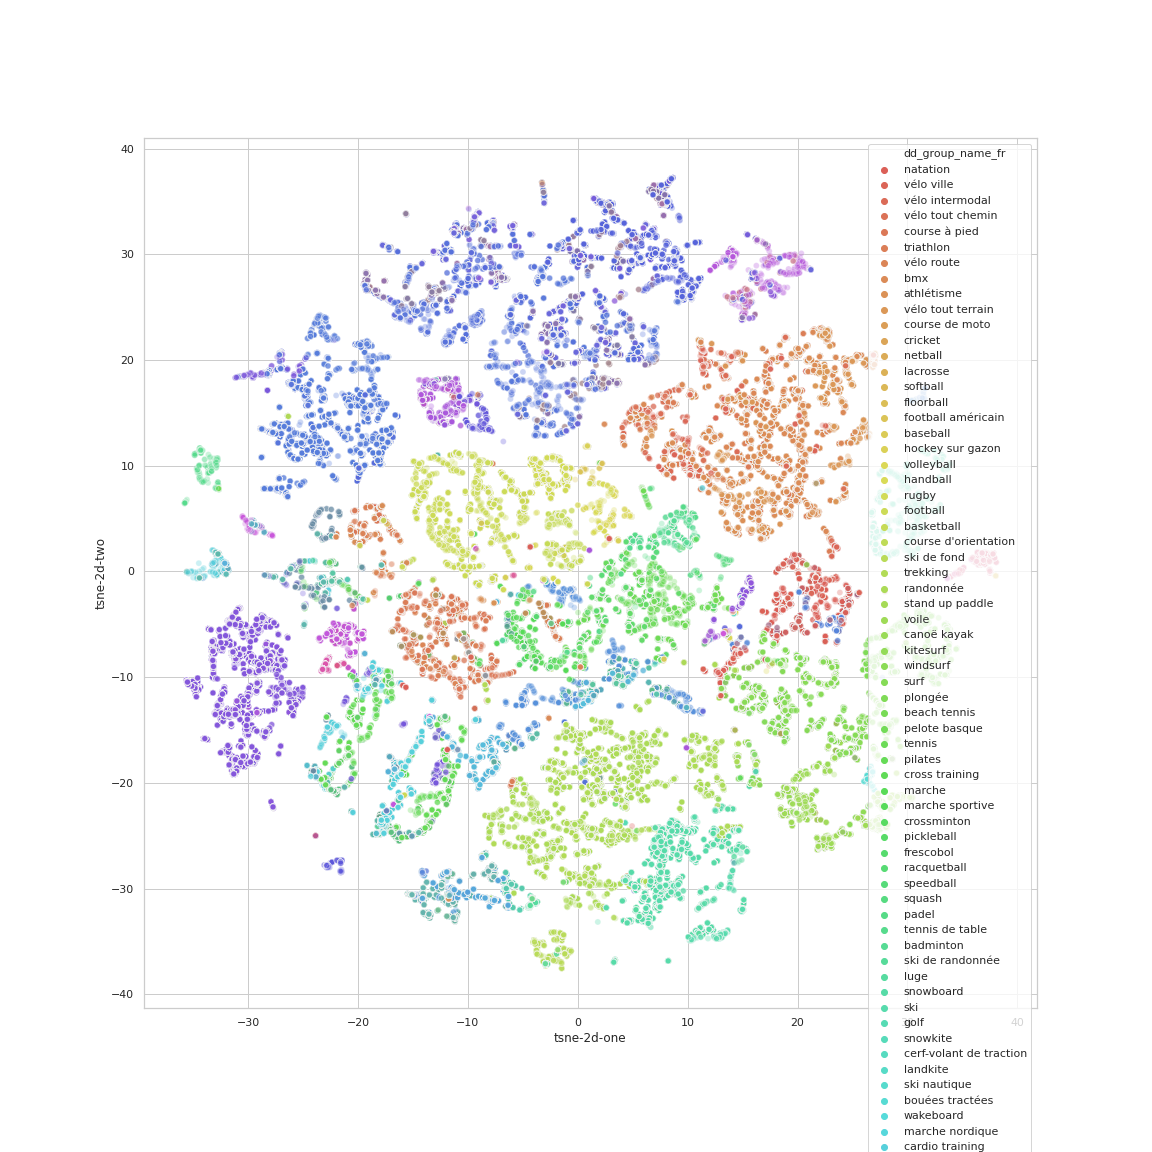

In [2]:
# visualize the entire semantic space and its mapping to the departments
plt.figure(figsize=(16, 16))
sns.set_style("whitegrid")
splot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='sport_label',
    palette=sns.color_palette("hls", n_aisle),
    data=df_semantic_item,
    legend="full",
    alpha=0.3
)
splot.figure.savefig("item_space_tsne.png")
plt.show()

We can see that the embeddings make very good sens, products belonging to the the same sport are close together ( colour coded ). We can also see that sports that are similar are close together ( e.g. trekking, hicking )

# Playing around with embeddings

In [ ]:
df_embed = pd.DataFrame.from_dict(item2vector_dict, orient="index")

In [ ]:
df_embed.head()

In [ ]:
df_embed.to_csv('models/item2vec_vectors.csv', sep=',')

#### Read embeddings

In [10]:
df_embed = pd.read_csv('models/item2vec_vectors.csv')
df_embed.rename(columns={'Unnamed: 0': 'dsm_code'}, inplace=True)

time: 1.3 s


In [ ]:
df_embed.head()

In [13]:
df_embed.shape

(23735, 201)

time: 32.5 ms


We can deduce embedding for sports and for users by aggregating the embedding of the products they are associated to

In [29]:
df_embed_sports_grp = df_embed_sports.groupby(['sport_group_id'])\
                                    .mean()

time: 116 ms


In [ ]:
df_embed_sports_grp.head()

### Compute distances between sports

In [67]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors 

time: 36.7 ms


In [70]:
X.shape, distance_matrix.shape

(50, 200)

time: 47.2 ms


In [ ]:
id_to_sport = df_info[['sport_id', 'sport_label']]\
                .drop_duplicates()\
                .set_index('sport_id').T.to_dict('list')
sport_to_id = df_info[['sport_id', 'sport_label']]\
                .drop_duplicates()\
                .set_index('sport_label').T.to_dict('list')

In [ ]:
knn = NearestNeighbors()
        
knn.fit(X)

In [218]:
def get_similar_sports(sport_name = 'gravel', sport_id = 196, k=3):
    
    if sport_name:
        
        sport_id = sport_to_id[sport_name][0]
        sport_index = [i for i in range(len(vocab)) if vocab[i]==sport_id]
        
        try:
            answers = knn.kneighbors(X[sport_index, :].reshape(1,-1), k, return_distance=True)
        except:
            return print("Sport not yet integrated")
        df_res = df_info[df_info['sport_id'].isin(vocab[answers[1]][0])][['sport_id', 'sport_label']]\
                    .drop_duplicates()
        
        df_res.loc[:, 'distance'] = answers[0][0]
        
        return df_res

time: 47.5 ms


In [ ]:
get_similar_sports(sport_name = 'gravel')
"""
Output:
cyclosport	0.000000
ravel	0.753062
bmx freestyle	1.392864
"""

In [ ]:
get_similar_sports(sport_name = 'randonnée montagne')
"""
Output:
randonnée nature	0.000000
randonnée montagne	1.032172
randonnée neige	2.730328
"""

In [ ]:
get_similar_sports(sport_name = 'cardio training')
"""
Output:
pilates	0.000000
RPM	3.549255
"""

In [ ]:
get_similar_sports(sport_name = "natation sportive")
"""
Output:
surf	0.000000
triathlon	7.055927
"""

In [ ]:
get_similar_sports(sport_name = "badminton")
"""
Output:
tennis	0.000000
tennis de table	4.554685
"""

In [ ]:
get_similar_sports(sport_name = 'voile habitable croisière')
"""
Output:
surf	0.000000
snorkeling	7.942842
"""

**The results are very promising !**
Considering that all we used for training were customer product purchases.